In [20]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import numpy as np


# Read the list of filenames from the configuration file
with open('file_list.txt', 'r', encoding='utf-8') as config_file:
    file_names = config_file.read().splitlines()

# Regex pattern to match the data format
pattern = r'\[(.*?)\] (.*?): (.*)'

# Initialize an empty list to store parsed data
datalist = []
stream_count = 0
# Iterate over each specified file
for file in file_names:
    full_path = "data\\"+file
    with open(full_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
        for line in lines:
            match = re.match(pattern, line)
            if match:
                date, user, message = match.groups()
                #user = user.lower() #try with this test
                datalist.append([date, user, message,stream_count])
    stream_count = stream_count + 1

# Create a DataFrame from the parsed data
data = pd.DataFrame(datalist, columns=["date", "user", "message","stream"])

#date to date format and sorting with it

data['date'] = pd.to_datetime(data['date'])
data = data.sort_values(by=['user', 'date'])

data["user"] = data["user"].replace("Banties1g", "banties_x")
data["user"] = data["user"].replace("banties1g", "banties_x")
data["user"] = data["user"].replace("fyodor_m_d1821", "fyredoor4")
data["user"] = data["user"].replace("chili_poe", "chili_con_bacon")
data["user"] = data["user"].replace("CHILI_POE", "chili_con_bacon")
data["user"] = data["user"].replace("Wirelesss_", "W1r3lesss")
data["user"] = data["user"].replace("treklul", "trek44_")
data["user"] = data["user"].replace("ttrek_", "trek44_")
data["user"] = data["user"].replace("TriplesingleJ", "TripleSingleJames")
data["user"] = data["user"].replace("uuccugr", "uwu_cougar")


# Extract all unique users from the other streams as a reference
#reference_users = set(data[data["stream"] != 302]["user"].unique())
# Extract users from stream 302
#stream_302_users = data[data["stream"] == 302]["user"]
# Create a mapping of lowercase to correct capitalization using the reference data
#user_mapping = {user.lower(): user for user in reference_users}
# Fix capitalization for users in stream 302
#fixed_users = stream_302_users.apply(lambda x: user_mapping.get(x.lower(), x))
# Count how many users needed to be fixed
#fix_count = (stream_302_users != fixed_users).sum()
# Update the data with fixed users
#data.loc[data["stream"] == 302, "user"] = fixed_users


#first messege for each user
data['first_message'] = data.groupby('user').cumcount().apply(lambda x: 1 if x == 0 else 0)


# Calculate the number of first messages per stream
first_messages_per_stream = data.groupby('stream')['first_message'].sum()


# Calculate the total number of messages per stream
total_messages_per_stream = data['stream'].value_counts()

# Combine the results into a single DataFrame
stream_stats = pd.DataFrame({
    'first_messages': first_messages_per_stream,
    'total_messages': total_messages_per_stream
})

# Calculate the time difference between the first and last messages for each stream
stream_lengths = data.groupby('stream')['date'].agg(lambda x: (x.max() - x.min()).total_seconds())

# Add the stream_length column to the stream_stats DataFrame
stream_stats['stream_length'] = stream_lengths

#stream length pre hour
stream_stats['stream_length_hour'] = stream_stats['stream_length'] /60 /60

# Path to your Excel file
file_path = 'DorozeaStreamStats.xlsx'

# Reading a specific sheet with custom column names and skipping the first two rows
exelStats = pd.read_excel(file_path, sheet_name='Munkalap1', header=None, names=['stream', 'avg', 'max','follow','games'], skiprows=1)

stream_stats = pd.merge(stream_stats, exelStats, on='stream', how='right')

#user with only 1 messege

# 1. Group by stream and user, and count the number of messages per user in each stream
user_message_counts = data.groupby(['stream', 'user']).size().reset_index(name='message_count')

# 2. Filter to keep only users who sent exactly one message in a stream
one_message_users = user_message_counts[user_message_counts['message_count'] == 1]

# 3. Count the number of such users for each stream
one_message_user_counts = one_message_users.groupby('stream').size().reset_index(name='one_message_user_count')

# 4. Merge this new information into the stream_stats dataframe
stream_stats = stream_stats.merge(one_message_user_counts, on='stream', how='left')

#hours watched
stream_stats['hours_watched'] = stream_stats['stream_length_hour'] * stream_stats['avg']

#total words count

# 1. Calculate the word count for each message
data['word_count'] = data['message'].apply(lambda x: len(x.split()))

# 2. Sum the word counts for each stream
stream_word_counts = data.groupby('stream')['word_count'].sum().reset_index(name='total_word_count')

# 3. Merge this new information into the stream_stats dataframe
stream_stats = stream_stats.merge(stream_word_counts, on='stream', how='left')

# If there are streams without any messages, fill NaN with 0
stream_stats['total_word_count'] = stream_stats['total_word_count'].fillna(0).astype(int)

#messege/min
stream_stats['message_per_min'] = stream_stats['total_messages'] / stream_stats['stream_length_hour'] / 60


subData = data[data.apply(lambda row: row['user'].lower() in row['message'].lower(), axis=1)]
subData =  subData[~subData['message'].str.contains(' converted from ', case=False, na=False)]

gifterData = subData[subData['message'].str.contains(' is gifting ', case=False, na=False)].copy()
gifterData['gifts'] = gifterData['message'].apply(lambda x: int(re.search(r'gifting\s(\d+)', x).group(1)))

gift_per_stream_2 = gifterData.groupby('stream')['gifts'].sum()

stream_stats = pd.merge(stream_stats, gift_per_stream_2, on='stream', how='left')

stream_stats = stream_stats.rename(columns={'gifts': 'gift2'})
stream_stats['gift2'] = stream_stats['gift2'].fillna(0)

giftedData = subData[subData['message'].str.contains(' sub ', case=False, na=False)]

gift_per_stream = giftedData.groupby('stream')['user'].count()

stream_stats = pd.merge(stream_stats, gift_per_stream, on='stream', how='left')

stream_stats = stream_stats.rename(columns={'user': 'gift'})
stream_stats['gift'] = stream_stats['gift'].fillna(0)

stream_stats['gift'] = np.maximum(stream_stats['gift'], stream_stats['gift2'])

primeData = subData[subData['message'].str.contains('Prime', case=False, na=False)]

prime_per_stream = primeData.groupby('stream')['user'].count()

stream_stats = pd.merge(stream_stats, prime_per_stream, on='stream', how='left')
stream_stats = stream_stats.rename(columns={'user': 'prime'})
stream_stats['prime'] = stream_stats['prime'].fillna(0)

trueSub =  subData[~ subData['message'].str.contains('Prime', case=False, na=False)]

trueSub = trueSub[~trueSub['message'].str.contains('gifting', case=False, na=False)]

trueSub = trueSub[~trueSub['message'].str.contains('gifted', case=False, na=False)]

trueSub = trueSub[trueSub['message'].str.contains(' subscribed at ', case=False, na=False)]

tier1 = trueSub[trueSub['message'].str.contains('Tier 1', case=False, na=False)]
tier2 = trueSub[trueSub['message'].str.contains('Tier 2', case=False, na=False)]
tier3 = trueSub[trueSub['message'].str.contains('Tier 3', case=False, na=False)]

tier1_per_stream = tier1.groupby('stream')['user'].count()
stream_stats = pd.merge(stream_stats, tier1_per_stream, on='stream', how='left')
stream_stats = stream_stats.rename(columns={'user': 'tier1'})
stream_stats['tier1'] = stream_stats['tier1'].fillna(0)

tier2_per_stream = tier2.groupby('stream')['user'].count()
stream_stats = pd.merge(stream_stats, tier2_per_stream, on='stream', how='left')
stream_stats = stream_stats.rename(columns={'user': 'tier2'})
stream_stats['tier2'] = stream_stats['tier2'].fillna(0)

tier3_per_stream = tier3.groupby('stream')['user'].count()
stream_stats = pd.merge(stream_stats, tier3_per_stream, on='stream', how='left')
stream_stats = stream_stats.rename(columns={'user': 'tier3'})
stream_stats['tier3'] = stream_stats['tier3'].fillna(0)

# Extract only the date (without time)
data['date_only'] = data['date'].dt.date

# Group by 'stream' and find the first message date
stream_date = data.groupby('stream')['date_only'].min().reset_index()

# Rename the columns appropriately
stream_date.columns = ['stream', 'stream_date']

# Merge the stream_date with the stream_stats DataFrame
stream_stats = stream_stats.merge(stream_date, on='stream', how='left')

# Convert stream_date to datetime if it is not already
stream_stats['stream_date'] = pd.to_datetime(stream_stats['stream_date'])

stream_stats['ad_rev'] = stream_stats['hours_watched'] * 0.004

#stream point
stream_stats['stream_points'] = (
    stream_stats['tier1'] * 1 +
    stream_stats['tier2'] * 2 +
    stream_stats['tier3'] * 6
)



In [21]:
stream_date.tail(24)

,stream,stream_date
283,283,2025-04-04
284,284,2025-04-05
285,285,2025-04-06
286,286,2025-04-07
287,287,2025-04-08
288,288,2025-04-09
289,289,2025-04-11
290,290,2025-04-12
291,291,2025-04-13
292,292,2025-04-14


In [22]:
stream_stats[['stream_date','stream']].tail(24)

,stream_date,stream
283,2025-04-04,283
284,2025-04-05,284
285,2025-04-06,285
286,2025-04-07,286
287,2025-04-08,287
288,2025-04-09,288
289,2025-04-11,289
290,2025-04-12,290
291,2025-04-13,291
292,2025-04-14,292


In [23]:
stream_stats['stream_points']

0       3.0
1       1.0
2       3.0
3       1.0
4       1.0
       ... 
302     9.0
303    20.0
304     7.0
305     3.0
306    20.0
Name: stream_points, Length: 307, dtype: float64

In [24]:
stream_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307 entries, 0 to 306
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   stream                  307 non-null    int64         
 1   first_messages          307 non-null    int64         
 2   total_messages          307 non-null    int64         
 3   stream_length           307 non-null    float64       
 4   stream_length_hour      307 non-null    float64       
 5   avg                     307 non-null    int64         
 6   max                     307 non-null    int64         
 7   follow                  307 non-null    int64         
 8   games                   307 non-null    object        
 9   one_message_user_count  307 non-null    int64         
 10  hours_watched           307 non-null    float64       
 11  total_word_count        307 non-null    int32         
 12  message_per_min         307 non-null    float64   

In [25]:
stream_stats.tail(2)

,stream,first_messages,total_messages,stream_length,stream_length_hour,avg,max,follow,games,one_message_user_count,...,message_per_min,gift2,gift,prime,tier1,tier2,tier3,stream_date,ad_rev,stream_points
305,305,152,4454,10055.0,2.793056,1001,1268,128,"jc, cs, r6",272,...,26.577822,6.0,7.0,12.0,3.0,0.0,0.0,2025-04-30,11.183394,3.0
306,306,299,12595,22757.0,6.321389,1421,1866,256,"jc, marvel",600,...,33.207365,20.0,21.0,24.0,14.0,0.0,1.0,2025-05-01,35.930774,20.0


In [26]:
# Convert stream_date to datetime format
stream_stats['stream_date'] = pd.to_datetime(stream_stats['stream_date'])

# Create a Year-Month column
stream_stats['year_month'] = stream_stats['stream_date'].dt.to_period('M')

In [27]:
# Group by Year-Month and sum the required numeric columns
monthly_data = stream_stats.groupby('year_month')[['prime', 'tier1', 'tier2', 'tier3','gift','ad_rev']].sum().reset_index()
monthly_data.set_index('year_month', inplace=True)
monthly_data['avg'] = stream_stats.groupby('year_month')['avg'].mean()
monthly_data.reset_index(inplace=True)
monthly_data['PartnerPlus'] = (
    stream_stats.groupby('year_month')['stream_points'].sum()
    .reindex(monthly_data['year_month'])  # Align to existing 'year_month'
    .values  # Use only the values for assignment
)



In [28]:
monthly_data

,year_month,prime,tier1,tier2,tier3,gift,ad_rev,avg,PartnerPlus
0,2024-05,80.0,75.0,1.0,3.0,191.0,98.621302,163.931034,95.0
1,2024-06,65.0,72.0,1.0,2.0,244.0,99.460279,205.956522,86.0
2,2024-07,102.0,96.0,1.0,4.0,793.0,118.660999,208.777778,122.0
3,2024-08,106.0,93.0,1.0,4.0,238.0,115.630142,241.380952,119.0
4,2024-09,120.0,154.0,1.0,6.0,1070.0,177.910924,274.615385,192.0
5,2024-10,158.0,165.0,1.0,2.0,1317.0,186.066281,344.384615,179.0
6,2024-11,129.0,127.0,1.0,8.0,2070.0,200.659684,404.041667,177.0
7,2024-12,202.0,212.0,2.0,15.0,1318.0,283.674678,494.074074,306.0
8,2025-01,323.0,256.0,7.0,26.0,1420.0,369.612638,738.076923,426.0
9,2025-02,476.0,479.0,8.0,23.0,2986.0,1030.490901,2216.916667,633.0


In [29]:
monthly_avg2 = stream_stats.groupby('year_month').apply(
    lambda x: (x['avg'] * x['stream_length_hour']).sum() / x['stream_length_hour'].sum()
).reset_index(name='avg2')

# Merge avg2 back into the original dataframe
monthly_data = monthly_data.merge(monthly_avg2, on='year_month', how='left')

C:\Users\Kardo\AppData\Local\Temp\ipykernel_8424\337569208.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  monthly_avg2 = stream_stats.groupby('year_month').apply(


In [30]:
monthly_avg2

,year_month,avg2
0,2024-05,165.904994
1,2024-06,216.289572
2,2024-07,209.680514
3,2024-08,243.267993
4,2024-09,273.719408
5,2024-10,349.268660
6,2024-11,416.701199
7,2024-12,500.949108
8,2025-01,729.220372
9,2025-02,2175.591988


In [31]:
# View the resulting DataFrame
monthly_data

,year_month,prime,tier1,tier2,tier3,gift,ad_rev,avg,PartnerPlus,avg2
0,2024-05,80.0,75.0,1.0,3.0,191.0,98.621302,163.931034,95.0,165.904994
1,2024-06,65.0,72.0,1.0,2.0,244.0,99.460279,205.956522,86.0,216.289572
2,2024-07,102.0,96.0,1.0,4.0,793.0,118.660999,208.777778,122.0,209.680514
3,2024-08,106.0,93.0,1.0,4.0,238.0,115.630142,241.380952,119.0,243.267993
4,2024-09,120.0,154.0,1.0,6.0,1070.0,177.910924,274.615385,192.0,273.719408
5,2024-10,158.0,165.0,1.0,2.0,1317.0,186.066281,344.384615,179.0,349.268660
6,2024-11,129.0,127.0,1.0,8.0,2070.0,200.659684,404.041667,177.0,416.701199
7,2024-12,202.0,212.0,2.0,15.0,1318.0,283.674678,494.074074,306.0,500.949108
8,2025-01,323.0,256.0,7.0,26.0,1420.0,369.612638,738.076923,426.0,729.220372
9,2025-02,476.0,479.0,8.0,23.0,2986.0,1030.490901,2216.916667,633.0,2175.591988


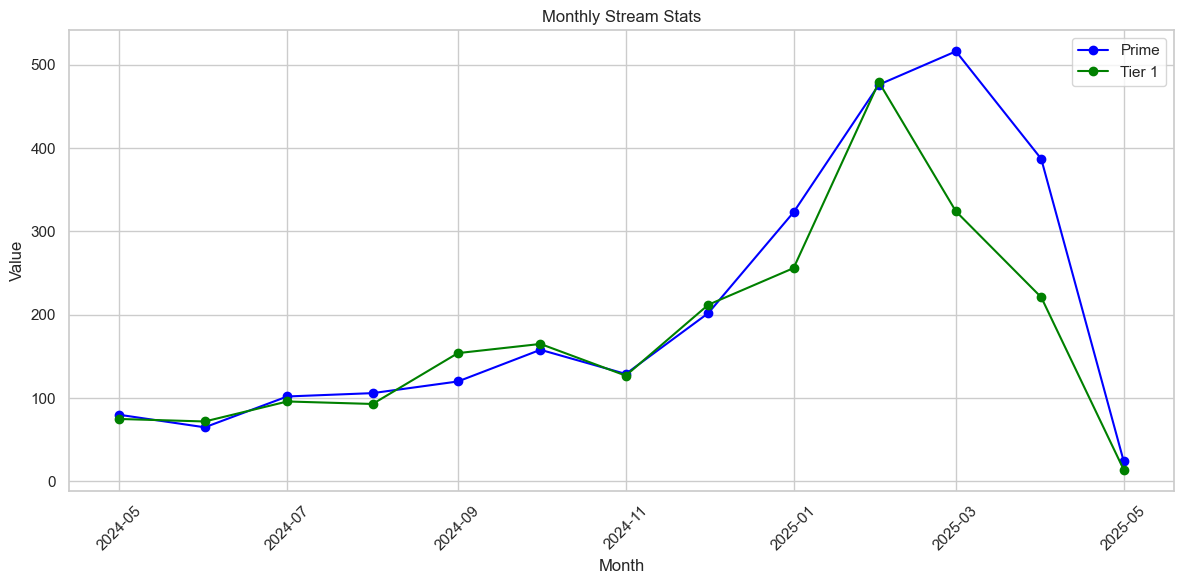

In [32]:
# Convert year_month to datetime for plotting
monthly_data['year_month'] = monthly_data['year_month'].dt.to_timestamp()

# Set the style for the plot
sns.set(style="whitegrid")

# Plotting the data
plt.figure(figsize=(12, 6))

# Plotting each column separately with a different color
plt.plot(monthly_data['year_month'], monthly_data['prime'], marker='o', label='Prime', color='blue')
plt.plot(monthly_data['year_month'], monthly_data['tier1'], marker='o', label='Tier 1', color='green')

# Adding titles and labels
plt.title('Monthly Stream Stats')
plt.xlabel('Month')
plt.ylabel('Value')

# Rotating the x-axis labels for better readability
plt.xticks(rotation=45)

# Adding a legend
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

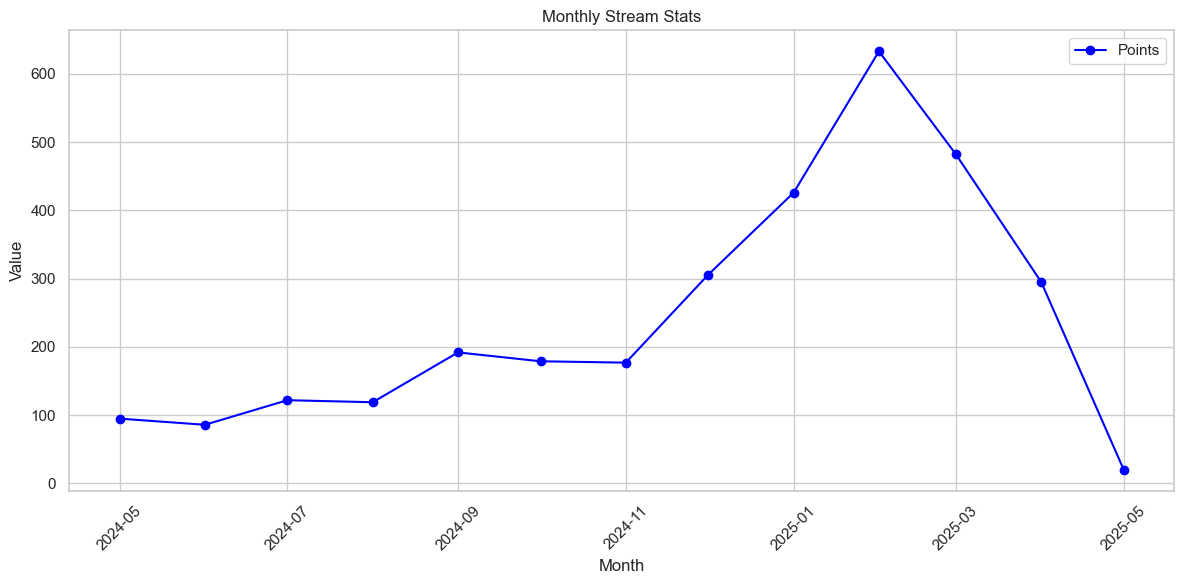

In [33]:
# Set the style for the plot
sns.set(style="whitegrid")

# Plotting the data
plt.figure(figsize=(12, 6))

# Plotting each column separately with a different color
plt.plot(monthly_data['year_month'], monthly_data['PartnerPlus'], marker='o', label='Points', color='blue')

# Adding titles and labels
plt.title('Monthly Stream Stats')
plt.xlabel('Month')
plt.ylabel('Value')

# Rotating the x-axis labels for better readability
plt.xticks(rotation=45)

# Adding a legend
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

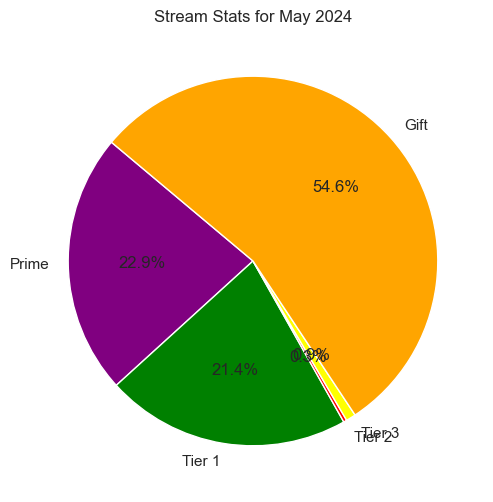

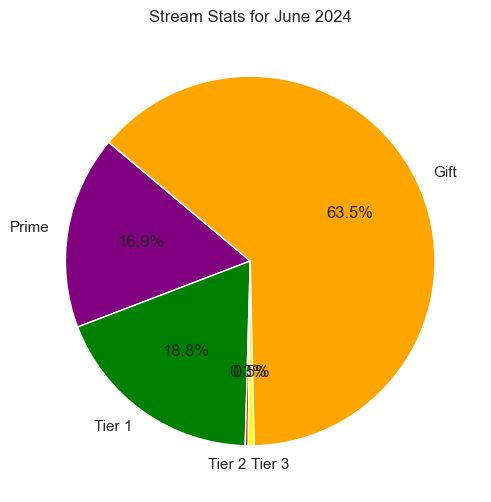

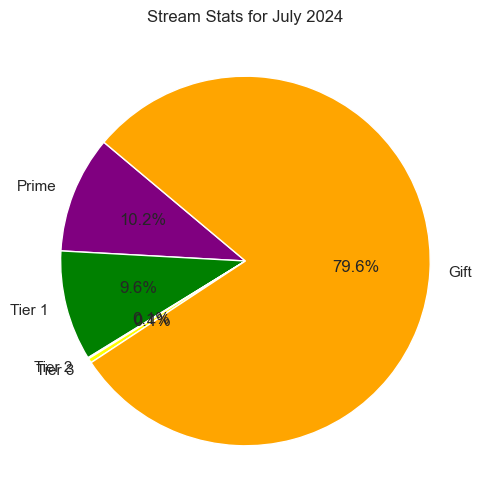

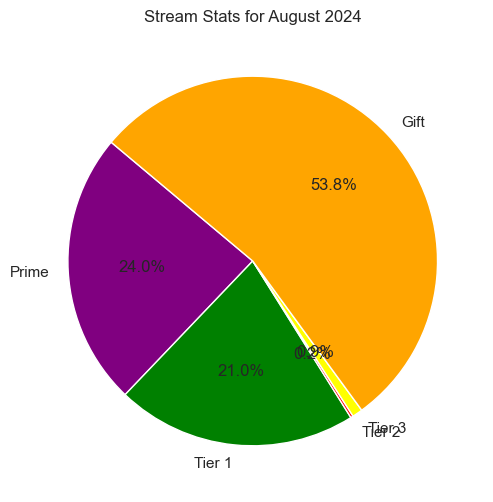

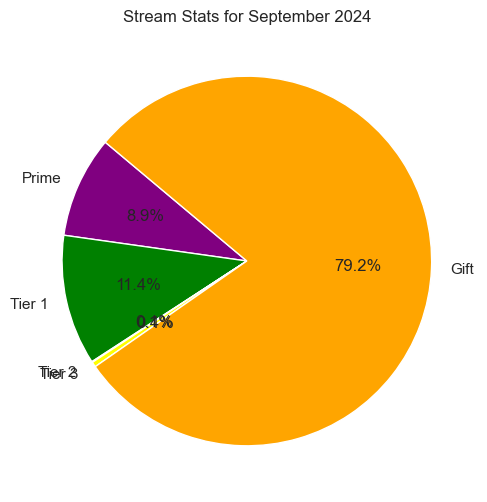

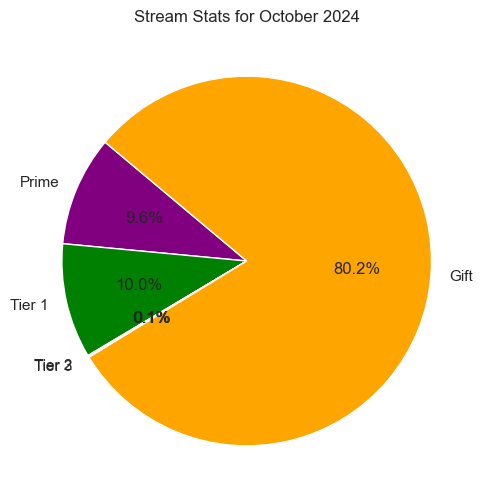

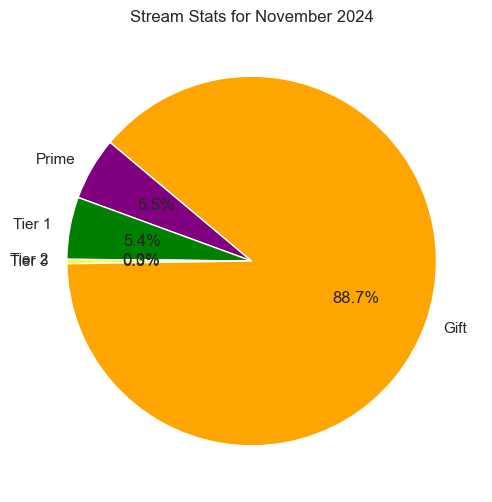

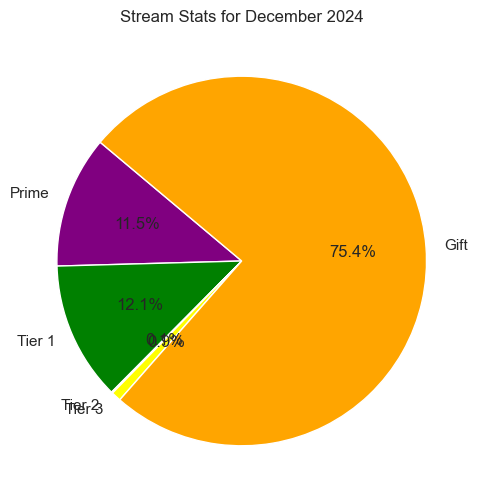

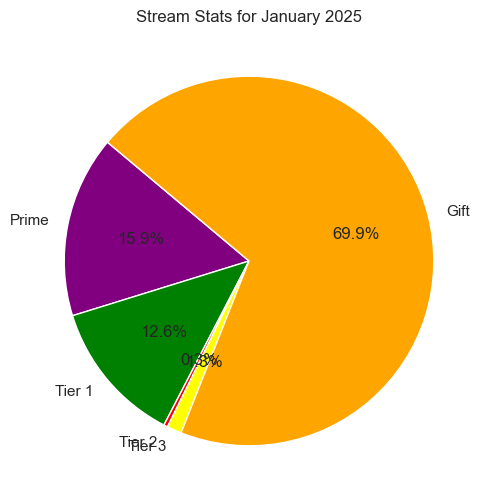

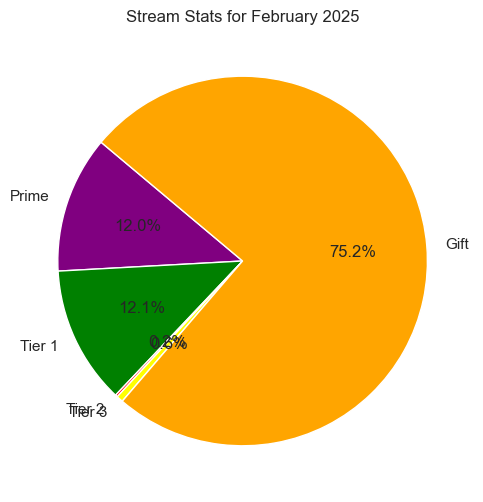

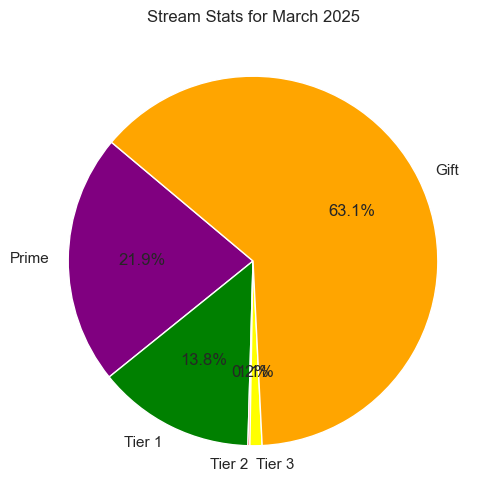

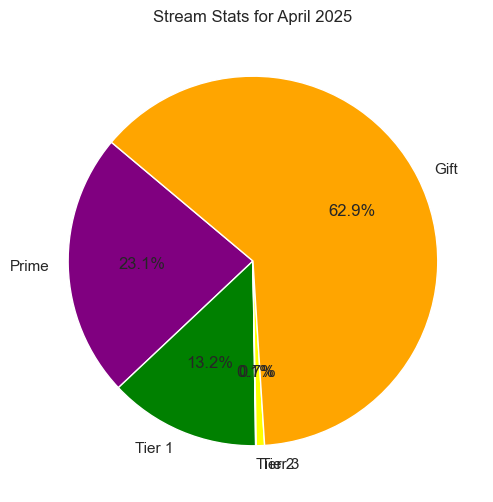

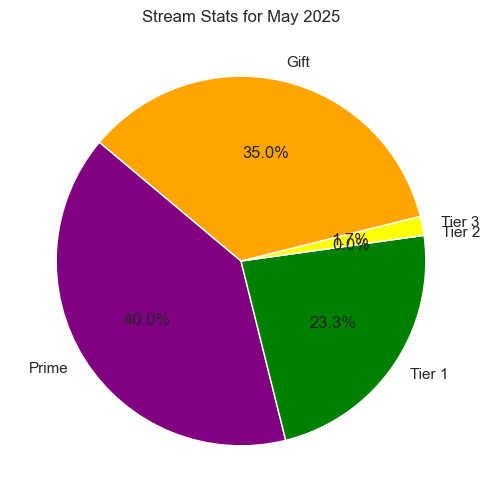

In [34]:
# Iterate through each row in the DataFrame to create a pie chart for each month
for index, row in monthly_data.iterrows():
    # Extract data for the current month
    labels = ['Prime', 'Tier 1', 'Tier 2', 'Tier 3', 'Gift']
    sizes = [row['prime'], row['tier1'], row['tier2'], row['tier3'], row['gift']]
    
    # Create a pie chart
    plt.figure(figsize=(6, 6))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=['purple','green', 'red', 'yellow', 'orange'])
    
    # Title the chart with the corresponding month
    plt.title(f"Stream Stats for {row['year_month'].strftime('%B %Y')}")
    
    # Display the plot
    plt.show()

In [35]:
#monthly_data.to_csv('month_data_output.csv', index=False)

In [36]:
monthly_data['sub_rev'] = monthly_data['prime'] * 1.4 + monthly_data['tier1'] * 1.4 + monthly_data['tier2'] * 2.8 + monthly_data['tier3'] * 5 + monthly_data['gift'] * 1.4
monthly_data

,year_month,prime,tier1,tier2,tier3,gift,ad_rev,avg,PartnerPlus,avg2,sub_rev
0,2024-05-01,80.0,75.0,1.0,3.0,191.0,98.621302,163.931034,95.0,165.904994,502.2
1,2024-06-01,65.0,72.0,1.0,2.0,244.0,99.460279,205.956522,86.0,216.289572,546.2
2,2024-07-01,102.0,96.0,1.0,4.0,793.0,118.660999,208.777778,122.0,209.680514,1410.2
3,2024-08-01,106.0,93.0,1.0,4.0,238.0,115.630142,241.380952,119.0,243.267993,634.6
4,2024-09-01,120.0,154.0,1.0,6.0,1070.0,177.910924,274.615385,192.0,273.719408,1914.4
5,2024-10-01,158.0,165.0,1.0,2.0,1317.0,186.066281,344.384615,179.0,349.268660,2308.8
6,2024-11-01,129.0,127.0,1.0,8.0,2070.0,200.659684,404.041667,177.0,416.701199,3299.2
7,2024-12-01,202.0,212.0,2.0,15.0,1318.0,283.674678,494.074074,306.0,500.949108,2505.4
8,2025-01-01,323.0,256.0,7.0,26.0,1420.0,369.612638,738.076923,426.0,729.220372,2948.2
9,2025-02-01,476.0,479.0,8.0,23.0,2986.0,1030.490901,2216.916667,633.0,2175.591988,5654.8


In [37]:
stream_stats.tail(5)

,stream,first_messages,total_messages,stream_length,stream_length_hour,avg,max,follow,games,one_message_user_count,...,gift2,gift,prime,tier1,tier2,tier3,stream_date,ad_rev,stream_points,year_month
302,302,188,5179,12201.0,3.389167,1239,1496,363,"jc, cs, r6",350,...,81.0,81.0,12.0,9.0,0.0,0.0,2025-04-26,16.796710,9.0,2025-04
303,303,210,10052,23181.0,6.439167,1163,1281,253,"jc, re8",380,...,0.0,2.0,22.0,8.0,0.0,2.0,2025-04-27,29.955003,20.0,2025-04
304,304,234,10449,21071.0,5.853056,961,1202,217,"jc, marbels, re8",365,...,38.0,40.0,11.0,7.0,0.0,0.0,2025-04-28,22.499146,7.0,2025-04
305,305,152,4454,10055.0,2.793056,1001,1268,128,"jc, cs, r6",272,...,6.0,7.0,12.0,3.0,0.0,0.0,2025-04-30,11.183394,3.0,2025-04
306,306,299,12595,22757.0,6.321389,1421,1866,256,"jc, marvel",600,...,20.0,21.0,24.0,14.0,0.0,1.0,2025-05-01,35.930774,20.0,2025-05


In [38]:
stream_stats['stream_date'] 

0     2024-05-01
1     2024-05-02
2     2024-05-03
3     2024-05-04
4     2024-05-05
         ...    
302   2025-04-26
303   2025-04-27
304   2025-04-28
305   2025-04-30
306   2025-05-01
Name: stream_date, Length: 307, dtype: datetime64[ns]